# 22.46 Procesamiento Adaptativo de Señales Aleatorias
## Trabajo Práctico N° 3
## Predicción Lineal
En este trabajo se buscará aplicar la estimación lineal óptima al caso particular de predicción lineal de señales de voz.

#### Grupo N° 1
* Davidov, Gonzalo Joaquín
* Farall, Facundo David
* Kammann, Lucas Agustín
* Trozzo, Rafael Nicolás

# 1. Grabaciones de voz
En esta sección, se estudiarán, analizarán y observarán aquellas grabaciones de voz sobre las cuales se aplicará la predicción lineal. Para ello, se grabaron sonidos /a/ y /sh/ de una persona utilizando una frecuencia de muestreo $f_s = 16kHz$.

Los sonidos deben ser grabados de la forma más estable posible en el tiempo, porque se busca asegurar la estacionariedad de la señal aleatoria. Normalmente, la señal de voz es únicamente estacionaria de forma local a un intervalo (de aproximadamente $20 ms$). Si la grabación tuviera estas características, los estadísticos de la señal cambiarían y el predictor lineal debería actualizarse continuamente. Es por eso que una característica esperada de las señales empleadas, es la estacionariedad.

Otro aspecto observado, es que es necesario asegurarse que las muestras utilizadas para la predicción, no incluyan los silencios iniciales y finales. Por eso, se recortan las señales de audio para evitar que esos fragmentos perturben los resultados obtenidos.

In [1]:
import matplotlib.pyplot as plt

In [2]:
from scipy.io import wavfile

In [3]:
import numpy as np

In [4]:
import IPython

In [5]:
import seaborn as sns

In [6]:
sns.set_style('dark')
sns.set_context('paper')
sns.set_palette('flare')

In [7]:
def plot_sound_analysis(samples, fs):
    """ Plots the signal and its spectrogram used in the analysis of the signals employed
        for the linear prediction in further sections.
        @param samples Samples of the signal
        @param fs Sampling frequency
    """
    # Create the plots
    fig = plt.figure(figsize=(16, 11))
    ax1 = fig.add_axes([0.1, 0.55, 0.7, 0.2])
    ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.35])
    ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.35])
    
    # Plot the signal
    ax1.plot(samples, label='Señal')
    ax1.set_xlabel('$n$', fontsize=15)
    ax1.set_ylabel('$x(n)$', fontsize=15)
    ax1.set_xlim((0, len(samples)))
    ax1.grid()
    
    # Plot the spectrogram to visualize the stationarity
    spectrum, freqs, t, im = ax2.specgram(samples, Fs=fs, cmap='plasma')
    ax2.tick_params(labelsize=15)
    ax2.set_title('Espectrograma', fontsize=18)
    ax2.set_xlabel('$t$ [s]', fontsize=16)
    ax2.set_ylabel('$f$ [Hz]', fontsize=16)
    
    # Plot the colorbar
    plt.colorbar(mappable=im, cax=ax3)

    # Show the plots
    plt.show()

## 1.1. Sonido /a/

In [8]:
# Choose /a/ sound recording
rec_a_filename = '../resources/recording_a_06.wav'

In [9]:
# Read the /a/ .wav file
rec_a_fs, rec_a_samples = wavfile.read(rec_a_filename)

In [10]:
# Remove silence
rec_a_samples = rec_a_samples[50000:140000]

In [11]:
# Estimate the mean, use it to create a zero mean random signal
# and normalize the signal using its standard deviation
rec_a_mean = rec_a_samples.mean()
rec_a_std = rec_a_samples.std()
rec_a_samples = (rec_a_samples - rec_a_mean) / rec_a_std

In [12]:
# Play the recorded sound
IPython.display.Audio(rec_a_samples, rate=rec_a_fs)

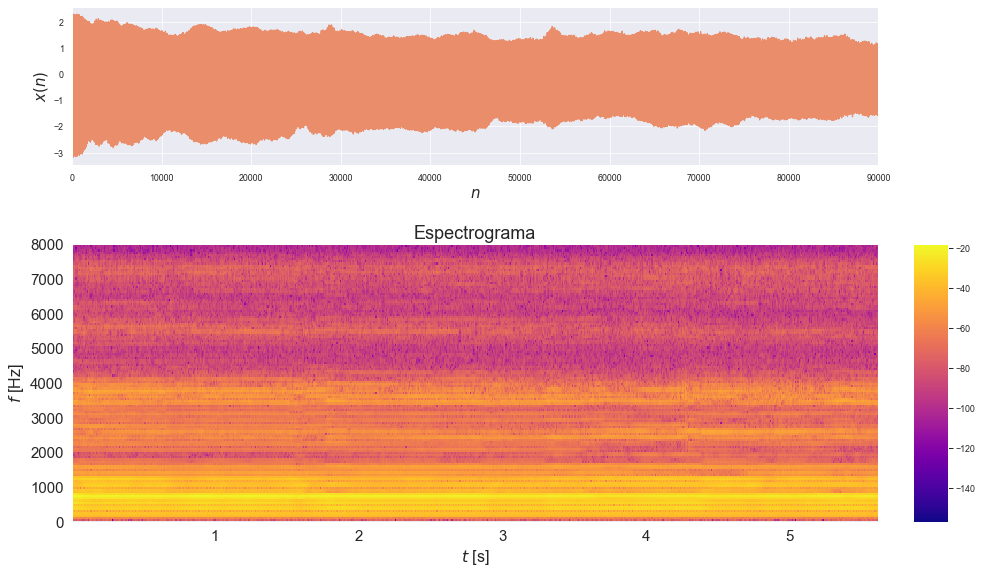

In [13]:
# Plot the analysis for the /a/ sound
plot_sound_analysis(rec_a_samples, rec_a_fs)

### 1.2. Sonido /sh/

In [14]:
# Choose /sh/ sound recording
rec_sh_filename = '../resources/recording_sh_06.wav'

In [15]:
# Read the /sh/ .wav file
rec_sh_fs, rec_sh_samples = wavfile.read(rec_sh_filename)

In [16]:
# Remove silence
rec_sh_samples = rec_sh_samples[20000:100000]

In [17]:
# Estimate the mean, use it to create a zero mean random signal
# and normalize the signal using its standard deviation
rec_sh_mean = rec_sh_samples.mean()
rec_sh_std = rec_sh_samples.std()
rec_sh_samples = (rec_sh_samples - rec_sh_mean) / rec_sh_std

In [18]:
# Play the recorded sound
IPython.display.Audio(rec_sh_samples, rate=rec_sh_fs)

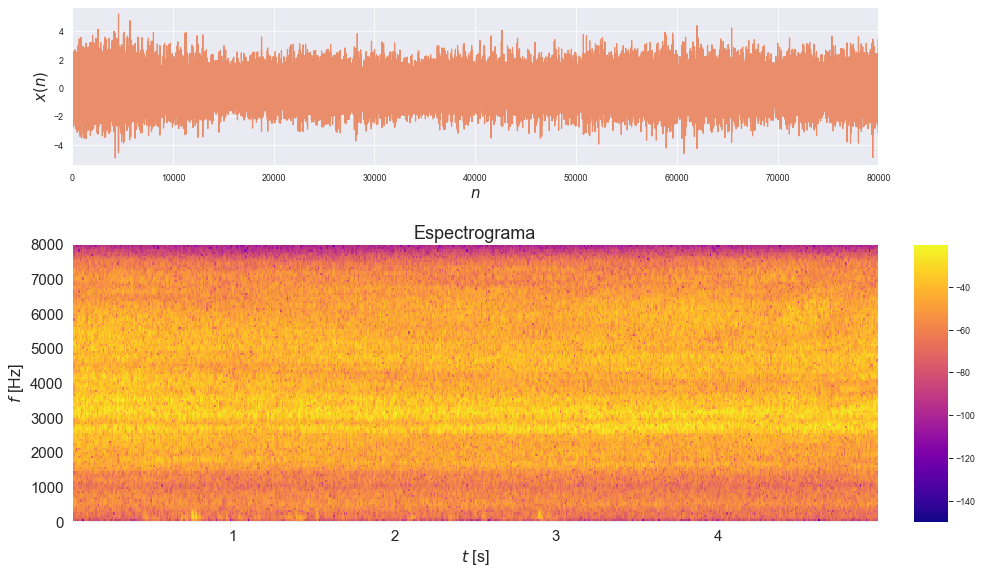

In [19]:
# Plot the analysis for the /a/ sound
plot_sound_analysis(rec_sh_samples, rec_sh_fs)

Observando el espectrograma del sonido /sh/ grabado, se puede concluir que tiene un espectro que contiene casi todas las frecuencias (dentro del espacio de frecuencias disponible por el dominio digital). Se puede establecer una analogía entre el sonido /sh/ y el ruido blanco, a partir de cómo suena y de observar su espectro de potencia.

## 2. Predicción lineal forward

In [20]:
from statsmodels.tsa import stattools

In [21]:
from scipy import signal

In [22]:
from scipy import linalg

In [23]:
def estimate_correlation(x, one_sided=True):
    """ Estimates the autocorrelation function of the input signal.
        @param x Input signal x(n)
        @return rxx
    """
    # Estimate the autocorrelation using the biased estimator
    rxx = signal.correlate(x, x, method='fft') / len(x)
    if one_sided:
        rxx = rxx[len(rxx)//2:]
    return rxx

In [24]:
def estimate_partial_correlation(x, k):
    """ Estimates the partial correlation coefficents of the input signal.
        @param x Input signal x(n)
        @param k Amount of partial correlation coefficients to calculate
        @return phikk
    """
    # Estimate the correlation coefficients
    rxx = estimate_correlation(x)
    rxx /= rxx[0]
    
    # Initialize the partial correlation
    phikk = np.array([rxx[1]])
    for i in range(2, k + 1):
        R = linalg.toeplitz(rxx[0:i])
        phi = np.dot(linalg.inv(R), rxx[1:i+1].reshape(-1, 1))
        phikk = np.concatenate((phikk, phi[-1]))
    
    # Return the result
    return phikk

In [25]:
def levinson_durbin(rxx):
    """ Computes the Levinson-Durbin algorithm to calculate the coefficients of an M order
        linear predictor, using the provided autocorrelation function.
        @param rxx Autocorrelation [rxx(0), rxx(1), ..., rxx(M)]
        @return (ao, J) -> Linear predictor coefficients and residual MSE of each order
    """
    # Compute the algorithm using a third-party library
    # and complete the missing values
    _, ao, _, J, _ = stattools.levinson_durbin(rxx, nlags=len(rxx)-1, isacov=True)
    J[0] = rxx[0]
    
    # Return the result
    return -ao, J

In [26]:
def optimum_linear_predictor(x, order):
    """ Get the optimum linear predictor for the random signal.
        @param x Random signal to predict
        @param order Order of the predictor
        @return (ao, J) -> Linear predictor coefficients and residual MSE of each order
    """
    # Estimate the autocorrelation
    rxx = estimate_correlation(x, one_sided=True)
    
    # Calculate the predictor using the Levinson-Durbin algorithm
    return levinson_durbin(rxx[:order+1])

In [27]:
def get_error_filter(coefficients):
    """ Get the error filter from the linear predictor coefficients.
        @param coefficients Coefficients of the linear predictor
        @return Coefficients of the error filter (FIR)
    """
    return np.concatenate(([1.0], coefficients))

In [28]:
def plot_correlation(x, length, title):
    """ Plot the correlation of the signal
        @param x Signal
        @param length Amount of lags to plot
        @param title Label
    """
    # Estimate the autocorrelation function
    rxx = estimate_correlation(x)
    
    # Plot the result
    plt.figure(figsize=(20, 8))
    plt.tick_params(labelsize=15)
    plt.stem(rxx[:length], label=title)
    plt.ylabel('$r_{xx}(n)$', fontsize=16)
    plt.xlabel('$n$', fontsize=16)
    plt.legend(fontsize=18)
    plt.grid()

In [37]:
def plot_mse_analysis(x, order, title):
    """ Plot the residual MSE when using the optimum linear predictor for the input signal, using different orders.
        @param x Random signal to predict
        @param order Maximum order to use
        @param title Title for the plot
    """
    # Compute the coefficients and residuals
    coefficients, residuals = optimum_linear_predictor(x, order)
    
    # Estimate the autocorrelation function
    rxx = estimate_correlation(x)
    
    # Estimate the partial correlation coefficients
    phikk = estimate_partial_correlation(x, order)
    
    # Plot the results
    fig, (ax2, ax1, ax3) = plt.subplots(3, 1, figsize=(20, 18))
    fig.suptitle(title, fontsize=18)
    
    ax1.semilogy(np.linspace(1, len(residuals[1:]), len(residuals[1:])), residuals[1:], color='red', label='MSE residual')
    ax1.tick_params(labelsize=15)
    ax1.set_ylabel('$\hat{J}_o$', fontsize=16)
    ax1.set_xlabel('$M$', fontsize=16)
    ax1.legend(fontsize=15)
    ax1.grid()
    
    ax2.stem(rxx[:order], label='Autocorrelación', use_line_collection=True)
    ax2.tick_params(labelsize=15)
    ax2.set_ylabel('$r_{xx}(n)$', fontsize=16)
    ax2.set_xlabel('$n$', fontsize=16)
    ax2.legend(fontsize=18)
    ax2.grid()
    
    ax3.tick_params(labelsize=15)
    ax3.stem(phikk, label='Coeficientes de correlación parcial', use_line_collection=True)
    ax3.set_ylabel('$\phi_{kk}$', fontsize=16)
    ax3.set_xlabel('$k$', fontsize=16)
    ax3.legend(fontsize=18)
    ax3.grid()
    
    plt.show()

In [30]:
def plot_error_analysis(x, order, fs, title):
    """ Plot samples and power spectrum density of input signal and error signal
        @param x Input signal
        @param order Order of the linear predictor
        @param fs Sampling frequency
        @param title Title
        @return The error signal
    """
    
    # Calculate the linear predictor, get the error filter
    # and apply the filtering to the input signal to retrieve
    # the error signal
    coefficients, residuals = optimum_linear_predictor(x, order)
    error_filter = get_error_filter(coefficients)
    error = signal.lfilter(error_filter, [1.0], x)
    
    # Cut the initial part of both the input and the error signals
    x = x[order:]
    error = error[order:]
    
    # Estimate the error power spectrum density
    fxx, Rxx = signal.welch(x, fs=fs, window='hamming', nperseg=2048)
    fee, Ree = signal.welch(error, fs=fs, window='hamming', nperseg=2048)
    
    # Plot results
    fig, ax = plt.subplots(3, 2, figsize=(20, 18))
    fig.suptitle(title, fontsize=25)
    
    ax[0][0].plot(x, label='Señal')
    ax[0][0].tick_params(labelsize=16)
    ax[0][0].legend(fontsize=16)
    ax[0][0].set_ylabel('$x(n)$', fontsize=16)
    ax[0][0].set_xlabel('$n$', fontsize=16)
    ax[0][0].set_xlim((0, len(x)))
    ax[0][0].grid()
    
    ax[1][0].plot(error, label='Error')
    ax[1][0].tick_params(labelsize=16)
    ax[1][0].legend(fontsize=16)
    ax[1][0].set_ylabel('$e(n)$', fontsize=16)
    ax[1][0].set_xlabel('$n$', fontsize=16)
    ax[1][0].set_xlim((0, len(error)))
    ax[1][0].grid()
    
    spectrum, freqs, t, im = ax[2][0].specgram(error, Fs=fs, cmap='plasma')
    ax[2][0].tick_params(labelsize=16)
    ax[2][0].set_ylabel('$f$ [Hz]', fontsize=16)
    ax[2][0].set_xlabel('$t$ [s]', fontsize=16)
    ax[2][0].grid()
    
    ax[0][1].semilogy(fxx, Rxx, label='Espectro de potencia de la señal')
    ax[0][1].tick_params(labelsize=16)
    ax[0][1].legend(fontsize=16)
    ax[0][1].set_ylabel('$R_{xx}(f)$', fontsize=16)
    ax[0][1].set_xlabel('$f$ [Hz]', fontsize=16)
    ax[0][1].grid()
    
    ax[1][1].semilogy(fee, Ree, label='Espectro de potencia del error')
    ax[1][1].tick_params(labelsize=16)
    ax[1][1].legend(fontsize=16)
    ax[1][1].set_ylabel('$R_{ee}(f)$', fontsize=16)
    ax[1][1].set_xlabel('$f$ [Hz]', fontsize=16)
    ax[1][1].grid()
    
    ax[2][1].axis('off')
    
    return error

## 2.1. Resultados
En esta sección se presentan los resultados de aplicar **FLP (Forward Linear Prediction)** al sonido /a/ y al sonido /sh/.

### 2.1.1. Sonido /sh/
Se calcula el predictor lineal óptimo para modelar la señal del sonido /sh/, y para ello se emplea el algoritmo de Levinson-Durbin, de esta forma se puede saber cómo evoluciona el error cuadrático medio residual ($J_o$). Para este análisis es evaluó $M \leq 150$, ya que luego de ejecutar diferentes pruebas, se observó que alcanza la planicie, y no tenía sentido calcular mayores órdenes.

Se grafican estimaciones de la autocorrelación y de los coeficientes de correlación parcial, además de $\hat{J_o}(n)$, porque aporta información visual a nuestro análisis.

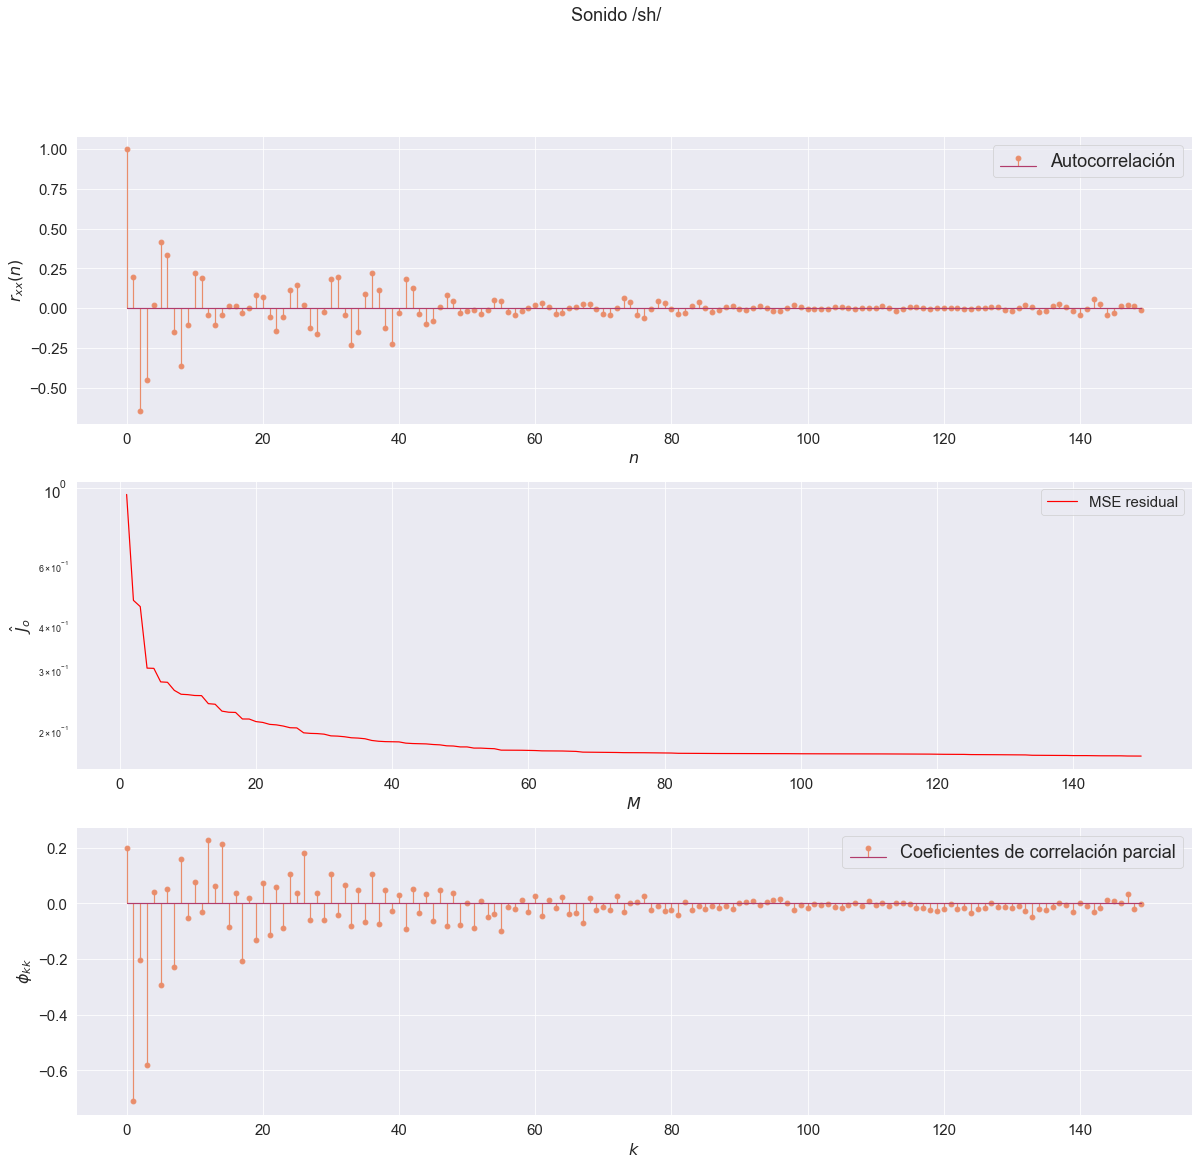

In [38]:
plot_mse_analysis(rec_sh_samples, 150, 'Sonido /sh/')

El gráfico es una estimación de la potencia del error en la predicción. La curva presenta un quiebre o codo que se debe a que el predictor lineal óptimo alcanzó a modelar la señal $x(n)$ como proceso autoregresivo de orden $m$, siendo que la misma es efectivamente un proceso autoregresivo de orden $m$. 

Cuando el orden $M < m$, si aumenta el orden, el predictor será capaz incluir en su predicción la correlación existente entre muestras más lejanas. Así, tendrá más información para su predicción, y el error será menor. No obstante, si la señal $x(n)$ es un proceso autoregresivo, no presentará correlación parcial entre muestras más alejadas que $m$. Por ende, cuando $M = m$, a partir de ahí aunque se suba el orden del predictor no existirá correlación alguna entre las muestras incluidas, con lo cual no habrá mejora alguna en el error de predicción. Es por esto que a partir de cierto órden se alcanza una planicie en la $J_o(M)$.

En el gráfico de la estimación de la función de autocorrelación para el sonido /sh/ se pueden notar dos puntos interesantes. En primer lugar, la forma de la función de autocorrelación es compleja (complicada de analizar visualmente), pero de todas formas tiene cierta analogía a una envolvente decayendo exponencialmente como es característico en procesos autoregresivos. En segundo lugar, la función de autocorrelación alcanza valores pequeños y despreciables cerca de $n = 80$. Esto es una buena intuición de por dónde está el orden del proceso autoregresivo, y es coherente con el resultado obtenido para el predictor lineal óptimo.

Además, es interesante observar que hay un paralelismo en cuanto a cómo es la correlación parcial y cómo o qué tanto mejora la potencia de error óptima. Por ende, se puede decir que la forma con la cual va decreciendo la potencia de error a medida que se incrementa el orden $M$ está dada por cómo son las correlaciones en cada órden (matemáticamente cuánto mejore $\hat{J_o}(M)$ está vinculado con cuánto vale $\phi_{MM}$. Es de esperarse que un proceso autoregresivo posea coeficientes de correlación parcial nulos para $k > M$ con $M$ el orden del proceso. En conclusión, los cambios abruptos presentes en la $\hat{J_o}(M)$ dependen de cómo sea la correlación parcial (qué información aporte) cada muestra nueva que se considera al aumentar el orden del predictor.

Cuando el predictor lineal óptimo posee un orden $M = m$, se dice que está **críticamente ajustado**, y tiene la propiedad de **whitening**. Esto se debe a que $x(n)$ se encuentra modelada completamente y de forma óptima, por ende, se habrá alcanzado la máxima correlación entre $\hat{x}(n)$ y $x(n)$, y el error $e(n) = x(n) - \hat{x}(n)$ contendrá todo aquello que no guarda correlación, que el predictor será incapaz de predecir, y por ende se denomina **innovación**. Es por estas características, que la señal de error será un ruido blanco, y su espectro será plano.

En el siguiente análisis, se grafica la señal $x(n)$ y una estimación espectral de su potencia $R_{xx}(f)$. Y luego, se grafica la señal de error $e(n)$ y una estimación espectral de su potencia $R_{ee}(f)$. Se agregó un gráfico de espectrograma porque para la estimación se está usando el método de **welch** o **periodogram averaging**, por ende es posible que en estas estimaciones se vean ocultados ciertos rasgos del espectro que cambian en el tiempo. En verdad esto no debería ser así, dado que la señal se asume y espera estacionaria, no obstante se incluye este análisis para detectar posibles problemas de estacionariedad.

En el análisis se escogió un $M = 80$ para el orden del predictor lineal, ya que de la curva anterior $\hat{J_o}(M)$ se observó que a partir de ese órden se mantiene aproximadamente constante (sin mejoras sustanciales), y al mismo tiempo se está buscando usar el menor orden posible para obtener un resultado eficiente. Es decir, la energía de la señal de error no disminuye significativamente conforme se aumenta el orden a partir de $M=80$, por eso no se usan órdenes mayores.

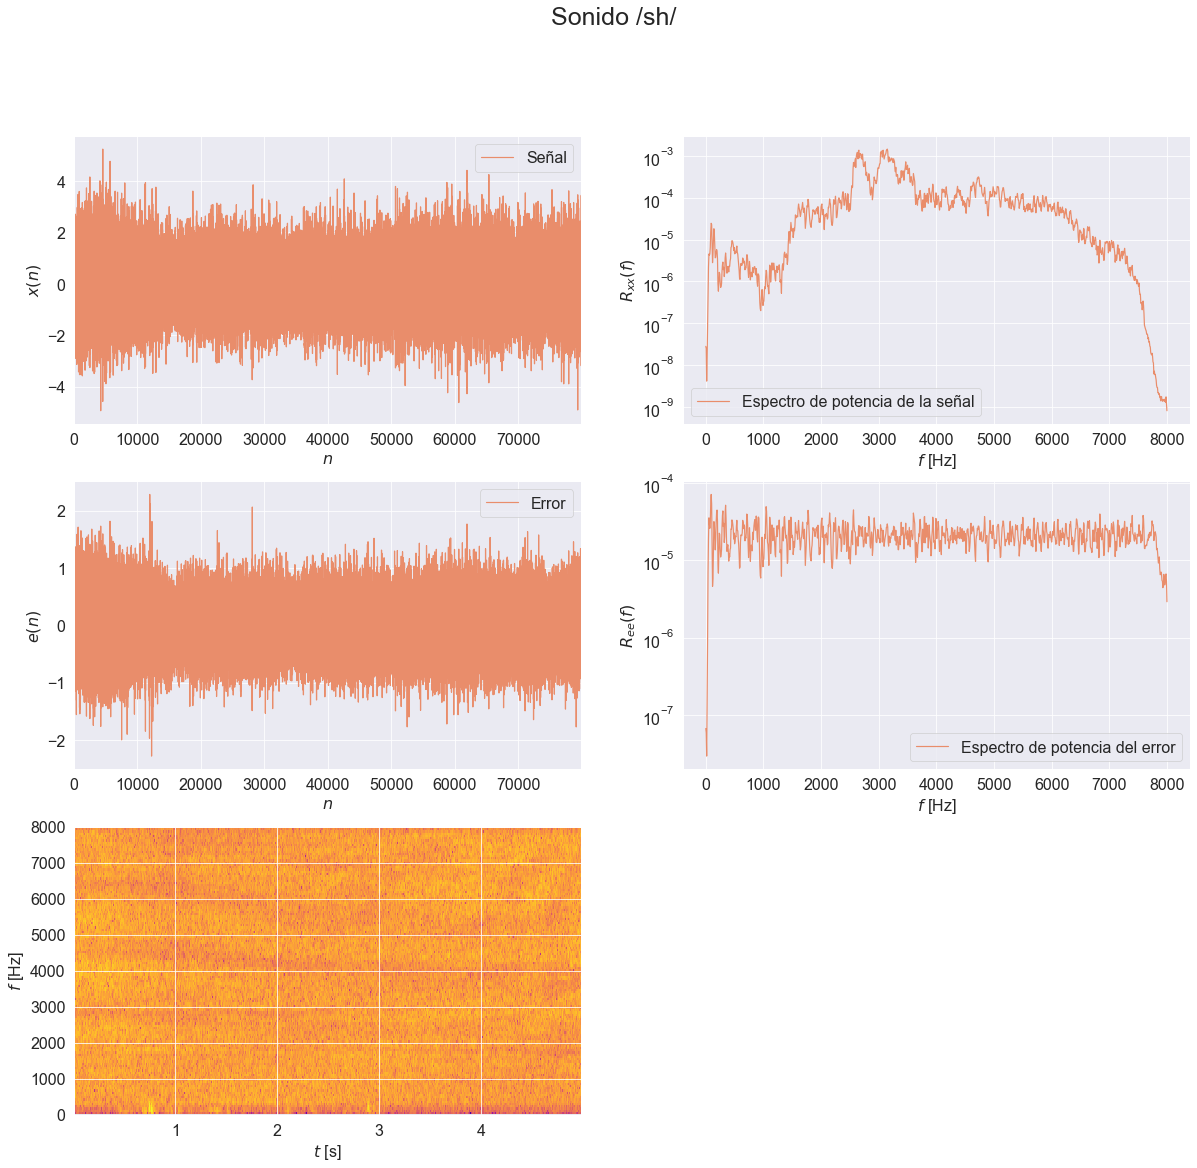

In [32]:
# Plot the error analysis
error = plot_error_analysis(rec_sh_samples, 80, rec_sh_fs, 'Sonido /sh/')

# Play the result
IPython.display.Audio(error, rate=rec_sh_fs)

Este resultado permite confirmar que la señal de error $e(n)$ es un ruido blanco, ya que su espectro de potencia es aproximadamente plano, lo cual además apoya la explicación de que el codo se produjo porque la señal estaba siendo modelada completamente como un proceso autorregresivo.

### 2.1.1. Sonido /a/
Para el sonido /a/, se realiza el mismo análisis que se hizo previamente para el sonido /sh/. En este caso, se utilizan órdenes $M \leq 200$, porque luego de varias pruebas se vió que mayores órdenes no aportaban cambios significativos, entonces no había razón alguna para incluirlos en la siguiente representación gráfica.

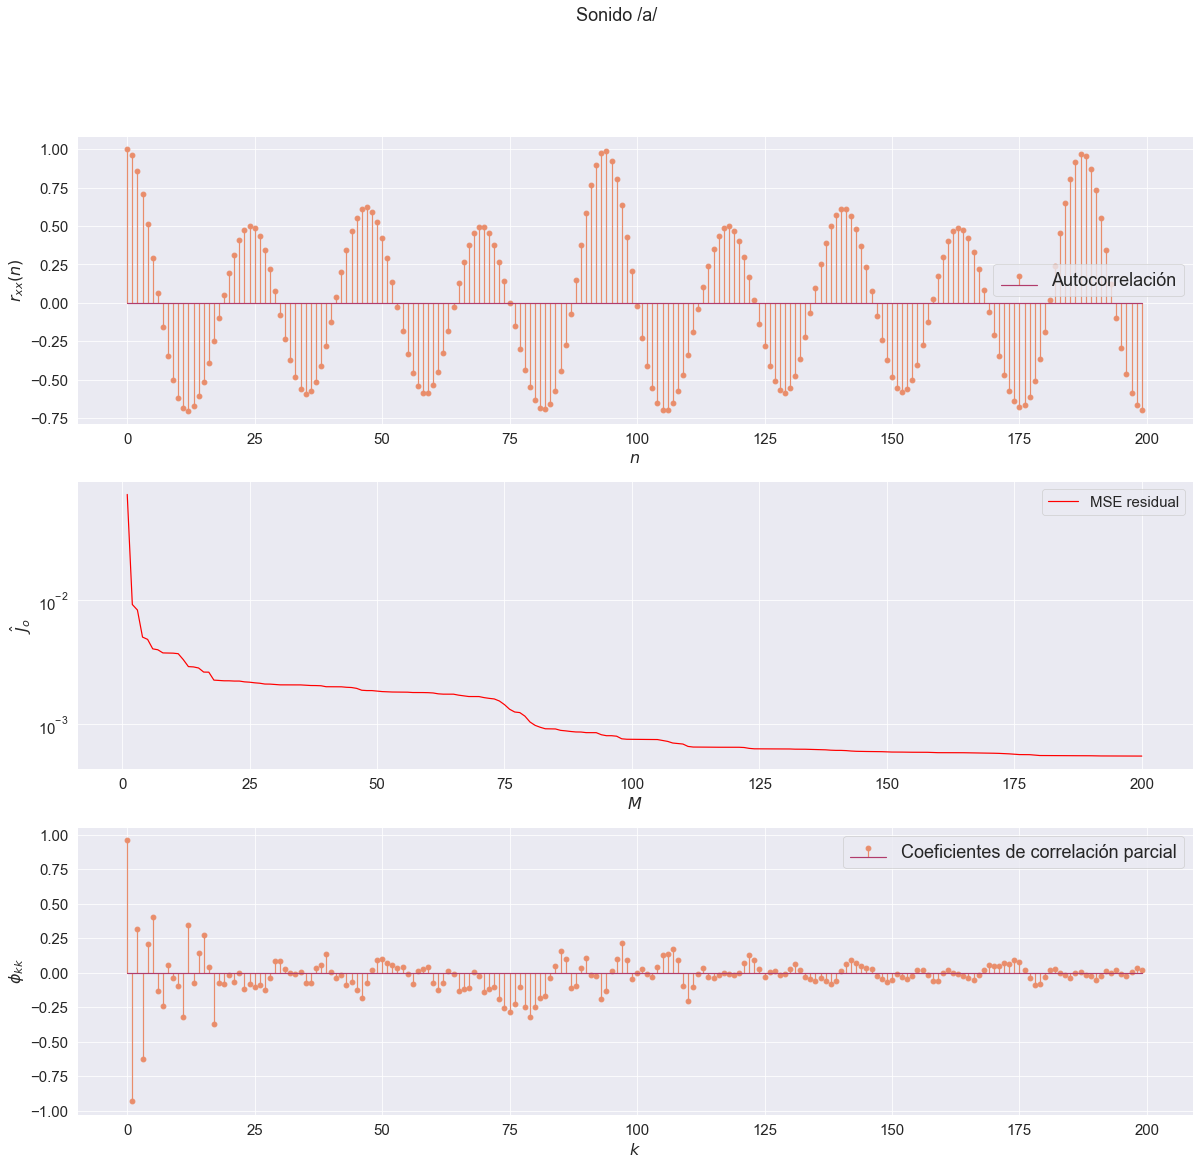

In [39]:
plot_mse_analysis(rec_a_samples, 200, 'Sonido /a/')

Para explicar la forma del gráfico $\hat{J_o}(M)$ es necesario utilizar la estimación de los coeficientes de correlación parcial. Sabemos que la función de autocorrelación permite medir el grado de relación entre dos muestras de una señal, pero esa relación puede ser directa o indirecta. En un proceso AR de la forma de $x(n) = 0.2 \cdot x(n-1) + v(n)$, la muestra $x(n-1)$ tiene un efecto directo sobre $x(n)$, mientras que las muestras pasadas tienen un efecto indirecto que permanece por la realimentación del proceso.

Si queremos conocer únicamente la relación directa que hay entre dos muestras, es necesario estudiar los **coeficientes de correlación parcial**. En este caso, es notable la diferencia entre la autocorrelación y la correlación parcial. De esta forma, utilizando la correlación parcial se puede conocer el efecto directo sobre la muestra actual a predecir, que tiene una muestra pasada en particular, que puede ser interpretado como cuánta información puede aportar conocer esa muestra pasada.

Con esto en mente, si se observa la estimación de las correlaciones parciales, para $k \leq 17$ las correlaciones parciales son elevadas y eso provoca una gran mejoría en el error de predicción. No obstante, a partir de ahí la correlación se hace muy pequeña y provoca que las muestras que se van agregando no aporten información que reduzca el error, lo cual origina una zona de planicie y el primer codo de la curva. Luego, en torno a $k = 75$, aparece una región de correlación parcial que provoca una nueva mejoría. Posteriormente, se vuelve a anular o hacer insignificante la magnitud de la correlación parcial, con lo cual esto origina una segunda planicie, y por ende, el segundo codo.

En conclusión, se puede atribuir que existen dos quiebres o codos en la estimación de la potencia de error óptima a las características de la señal de voz utilizada, particularmente, a cómo sean las correlaciones. Se puede pensar que a medida que se aumenta $M$, la evolución de $\hat{J_o}(M)$ estará dada por qué información aporte la nueva muestra incluida al incrementar el orden, y dado que existe una región de muestras incorrelacionadas, aparece una zona casi constante que da lugar a un segundo codo.

Para analizar la señal de error, se eligió un $M = 150$, ya que es el menor orden para el cual se alcanza una potencia de error a partir de la cual no hay mejorías significativas. De esta forma se mantiene en uso un predictor lineal eficiente en cantidad de coeficientes y resultado obtenido.

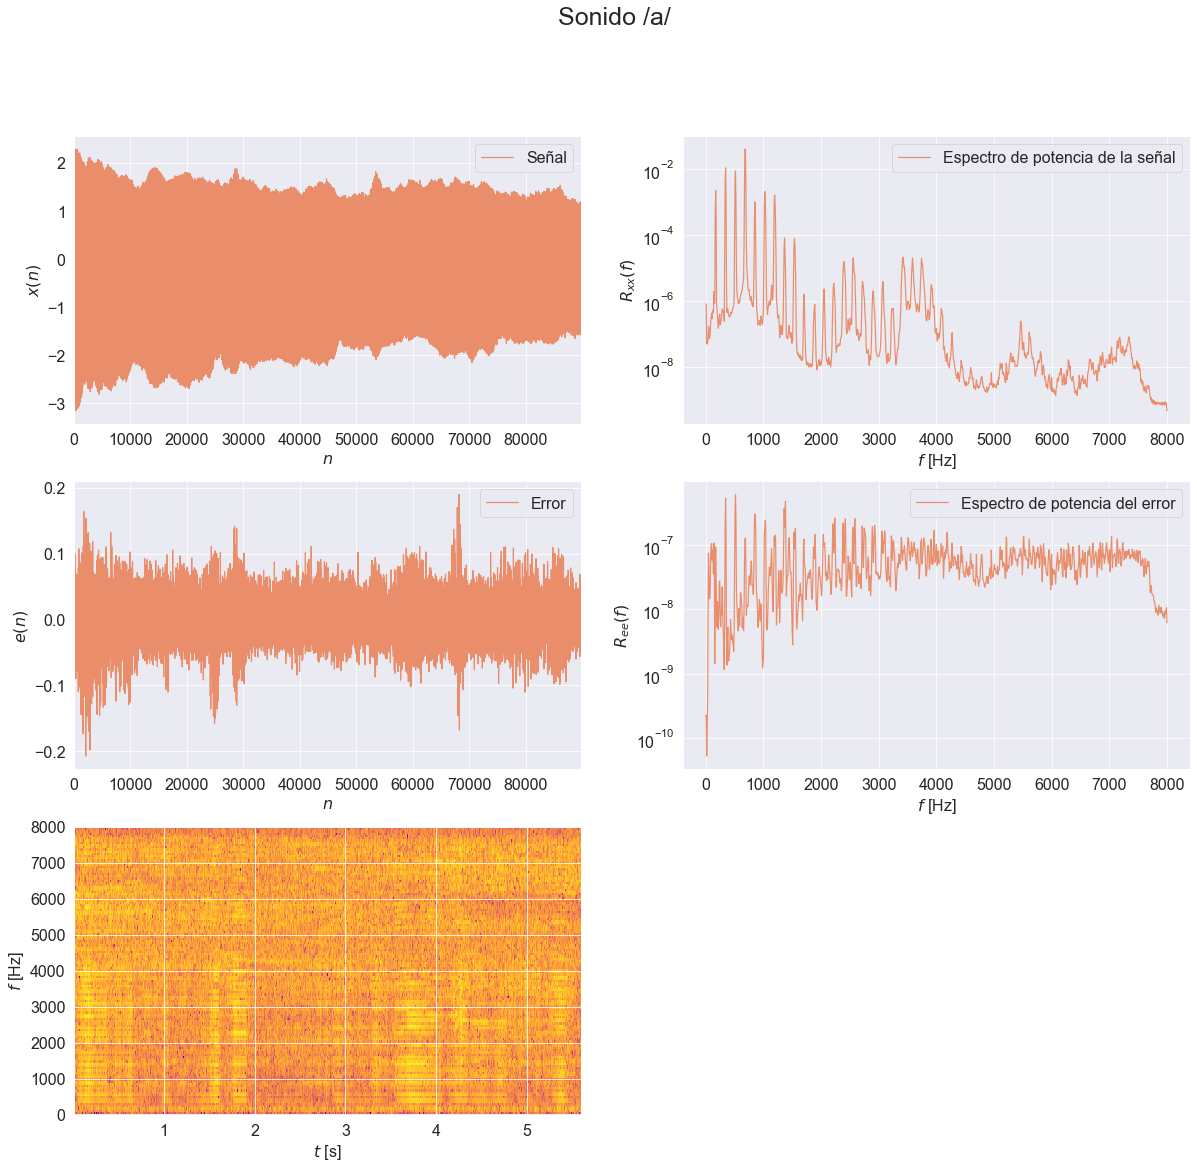

In [34]:
# Plot the error analysis
error = plot_error_analysis(rec_a_samples, 150, rec_a_fs, 'Sonido /a/')

# Play the result
IPython.display.Audio(error, rate=rec_a_fs)

A partir de analizar la señal de error del predictor lineal, se observa que tiende a poseer un espectro plano, no obstante no alcanza exactamente a serlo. Por ende, se puede asumir que la señal de error no es una señal de innovaciones o incorrelacionada. Esto quiere decir que el predictor no fue capaz de remover toda la redundancia presente en la señal de entrada, y un factor al cual se puede atribuir esto, es que la señal de voz empleada no sea un proceso autoregresivo. Esto último implicaría que el predictor no es capaz de modelar completamente el comportamiento del proceso, y todo aquello que no es capaz de modelar se refleja como un grado de correlación que prevalece en la señal de error.